<a href="https://colab.research.google.com/drive/1ajDFB38ksufUiXmtms4IwvqnkMUyr7dz?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Github Link: [https://github.com/CuriousChum/JSC270_HW2_2024_LRTan](https://github.com/CuriousChum/JSC270_HW2_2024_LRTan)

###Libraries you'll likely need

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

###Importing data

In [49]:
income94 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)
income94.columns = ['age','workclass', 'fnlwgt','education','education_num','marital_status','occupation',
                    'relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','gross_income_group']

# Initial Data Exploration

### Check columns
The data types of each column is as expected based on [https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names)

In [50]:
income94.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   age                 32561 non-null  int64 
 1   workclass           32561 non-null  object
 2   fnlwgt              32561 non-null  int64 
 3   education           32561 non-null  object
 4   education_num       32561 non-null  int64 
 5   marital_status      32561 non-null  object
 6   occupation          32561 non-null  object
 7   relationship        32561 non-null  object
 8   race                32561 non-null  object
 9   sex                 32561 non-null  object
 10  capital_gain        32561 non-null  int64 
 11  capital_loss        32561 non-null  int64 
 12  hours_per_week      32561 non-null  int64 
 13  native_country      32561 non-null  object
 14  gross_income_group  32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


### Checking the values in string type columns

Notice that missing values in the columns are represented by " ?". Also, there is a whitespace in from of the string columns, we remove those as well for convenience.

In [51]:
strtypes = income94[[str(col) for col, dtype in income94.dtypes.items() if dtype == "object"]]

In [52]:
for col in strtypes:
    print(f"Column: {col}")
    print(strtypes[col].unique())
    print("\n")


Column: workclass
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']


Column: education
[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']


Column: marital_status
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']


Column: occupation
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']


Column: relationship
[' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']


Column: race
[' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']


Column: sex
[' Male' ' Fem

In [53]:
for col in strtypes:
    income94[col] = income94[col].str.strip()

#### We replace these missing values with np.NaN.

In [54]:
income94.replace("?", np.NaN, inplace=True)

### Plotting the distribution of capital_gain and capital_loss

I believe we can transform these columns to categorical types since the majority of them are zero. So, we can create a 'zero' and 'nonzero' category for these.

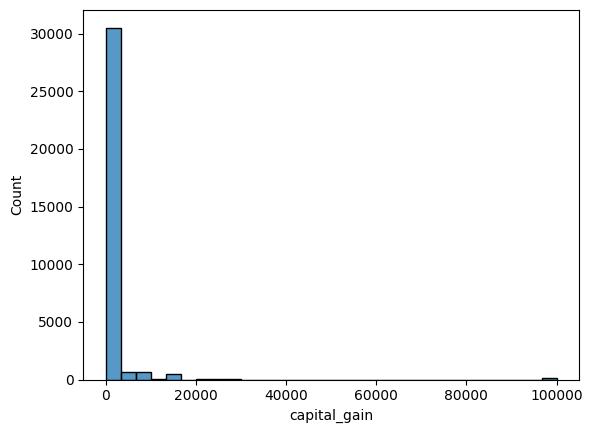

Number of nonzero values: 2712


In [55]:
sns.histplot(income94, bins=30, x="capital_gain", kde=False)
plt.show()
print(f'Number of nonzero values: {(income94["capital_gain"] > 0).sum()}')

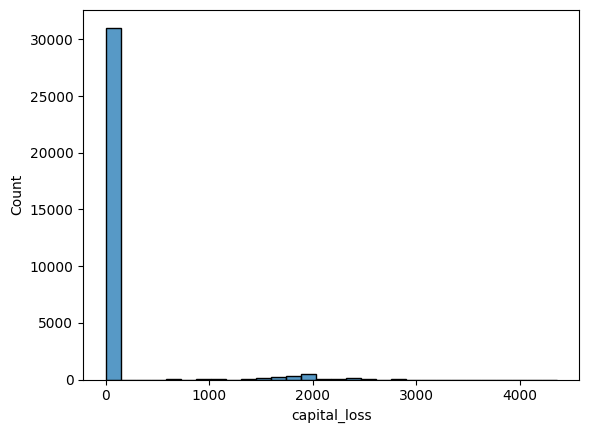

Number of nonzero values: 1519


In [56]:
sns.histplot(income94, bins=30, x="capital_loss", kde=False)
plt.show()
print(f'Number of nonzero values: {(income94["capital_loss"] > 0).sum()}')

### Add new transformed columns

In [57]:
income94["has_capital_gain"] = (income94["capital_gain"] > 0)
income94["has_capital_loss"] = (income94["capital_loss"] > 0)

income94.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   age                 32561 non-null  int64 
 1   workclass           30725 non-null  object
 2   fnlwgt              32561 non-null  int64 
 3   education           32561 non-null  object
 4   education_num       32561 non-null  int64 
 5   marital_status      32561 non-null  object
 6   occupation          30718 non-null  object
 7   relationship        32561 non-null  object
 8   race                32561 non-null  object
 9   sex                 32561 non-null  object
 10  capital_gain        32561 non-null  int64 
 11  capital_loss        32561 non-null  int64 
 12  hours_per_week      32561 non-null  int64 
 13  native_country      31978 non-null  object
 14  gross_income_group  32561 non-null  object
 15  has_capital_gain    32561 non-null  bool  
 16  has_capital_loss    32

### Exploring the variable *fnlwgt*

Looking at histogram of *fnlwgt* and its values, we see that the spread is quite large and the data is right-skewed with a thin tail. Looking at its log10 transformed values and keeping it in the variable *log_fnlwgt*, we can see a graph that looked almost bell-shaped.

Notice that the *fnlwgt* distribution seemingly vanish after the value 0.8 * 1e6. We will consider values above this threshold as outliers and remove them.

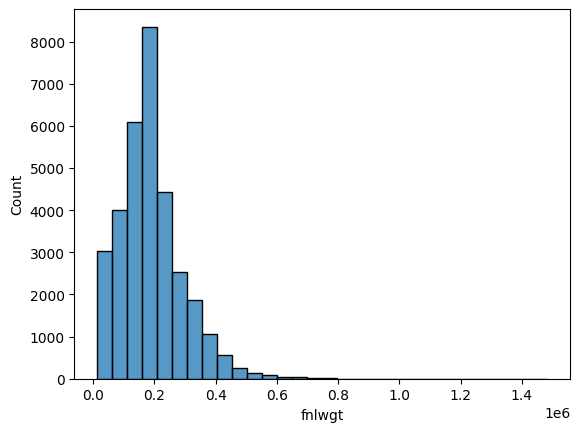

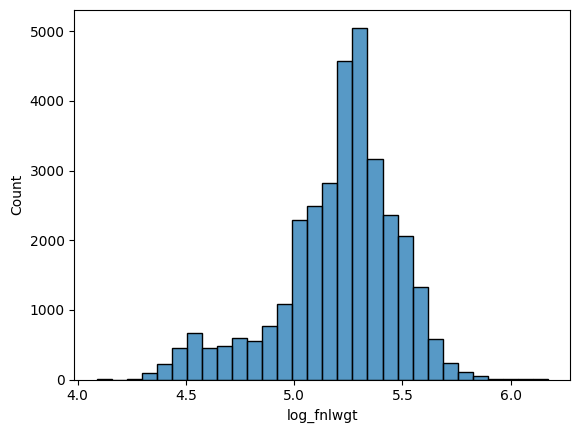

In [58]:
income94["log_fnlwgt"] = np.log10(income94['fnlwgt'])
sns.histplot(income94, bins=30, x="fnlwgt")
plt.show()
sns.histplot(income94, bins=30, x="log_fnlwgt")
plt.show()

##### After removing outliers

kde is added for shape estimate.

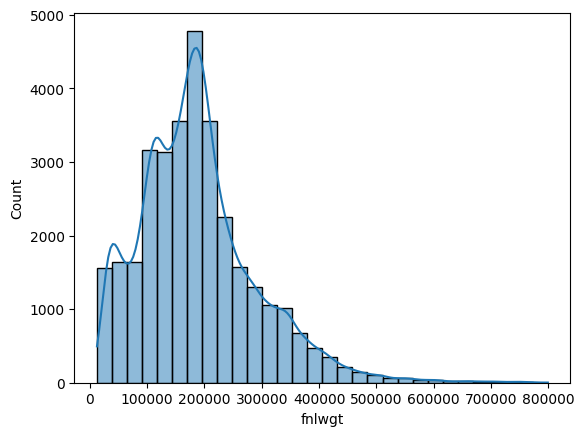

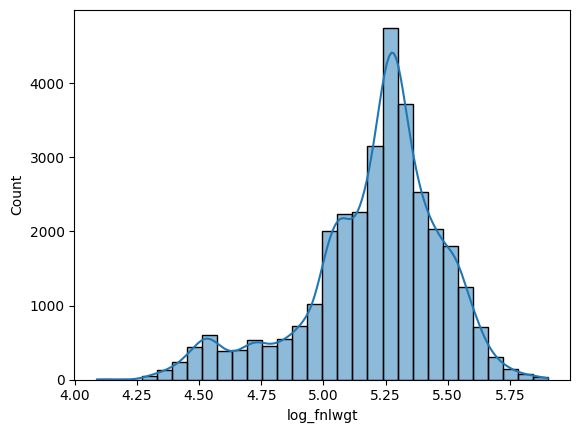

In [59]:
income94["fnlwgt"] = income94["fnlwgt"].apply(lambda x: x if x <= 0.8 * 1e6 else np.NaN)
income94["log_fnlwgt"] = income94["fnlwgt"].apply(np.log10)

sns.histplot(income94, bins=30, x="fnlwgt", kde=True)
plt.show()
sns.histplot(income94, bins=30, x="log_fnlwgt", kde=True)
plt.show()

### Comparison between the sexes

Comparing the violin plots of the *fnlwgt* and *log_fnlwgt* with respect to the sexes, the plot are identical. Thus, the distribution for each sexes are identical.

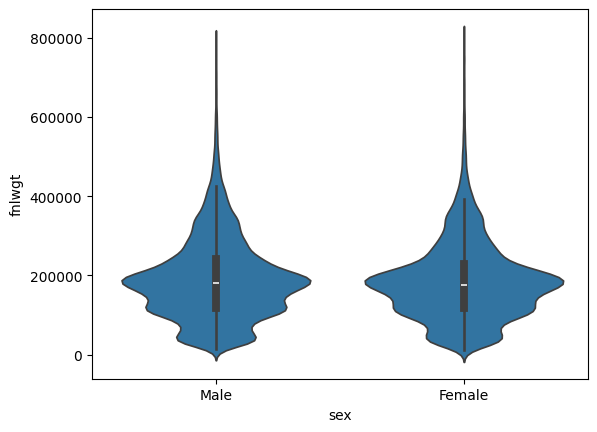

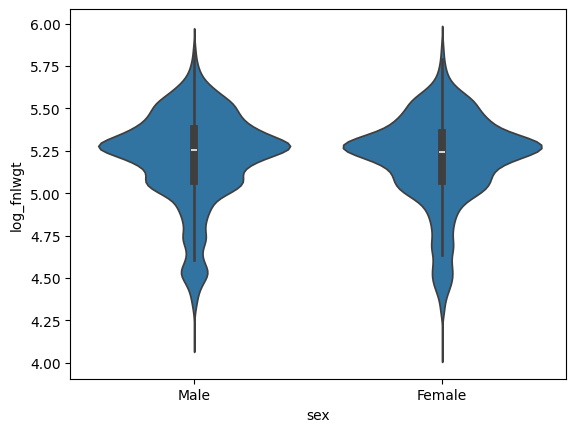

In [60]:
sns.violinplot(income94, y="fnlwgt", x="sex")
plt.show()
sns.violinplot(income94, y="log_fnlwgt", x="sex")
plt.show()

Looking directly at the statistics of the data, we can see that they are also
identical, only there are approx. two times as much male data points than female.

In [61]:
income94[["sex", "fnlwgt", "log_fnlwgt"]].groupby("sex").describe().T

sex                      Female           Male
fnlwgt     count   10760.000000   21772.000000
           mean   184880.186338  191087.994764
           std     99184.468094  103978.408124
           min     12285.000000   13769.000000
           25%    117350.500000  118116.250000
           50%    176046.500000  180087.500000
           75%    227988.000000  240861.500000
           max    799281.000000  791084.000000
log_fnlwgt count   10760.000000   21772.000000
           mean        5.196124       5.207553
           std         0.269229       0.274773
           min         4.089375       4.138902
           25%         5.069485       5.072310
           50%         5.245627       5.255484
           75%         5.357912       5.381767
           max         5.902699       5.898223

# Correlation

### Finding correlations between *age*, *education_num*, and *hours_per_week*
Looking at the correlation matrix and heatmap, there seem to be little correlation between the variables, with the largest correlation being between *hours_per_week* and *education_num*

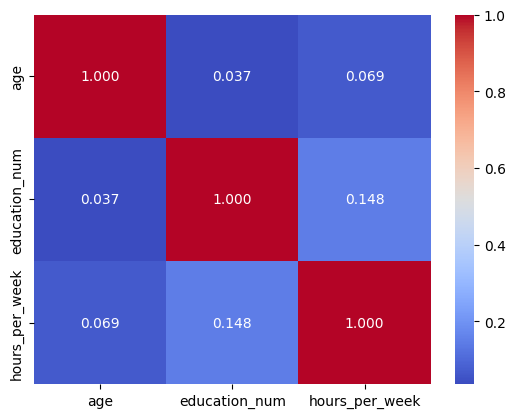

In [62]:
subdf = income94[["age", "education_num", "hours_per_week"]]

sns.heatmap(subdf.corr(), annot=True, cmap="coolwarm", fmt=".3f")
plt.show()

We perform a test with the 'pearsonr' function from scipy.stats. This function returns the correlation coefficient and the p value. Based on [the documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#r8c6348c62346-3), the p value is obtained from the hypothesis test with null hypothesis "the distribution underlying the variables are uncorrelated and normally distributed". Notice p_val << 0.05, so we can reject the null.

Furthermore, performing an OLS regression shows the f-statistic to be << 0, so we can reject the null hypothesis of "the coefficients of all the predictor variables in the full model are jointly equal to zero" used for the f-test.


In [63]:
pearson_coef, p_val = stats.pearsonr(income94.education_num, income94.hours_per_week)

print(f"The correlation between education_num and hours_per_week is {pearson_coef:.3f}, with corresponding p value {p_val}.")

print("\n")
print("Performing an OLS regression on the variables, we have")
reg = smf.ols("education_num ~ hours_per_week", data=income94).fit()
print(reg.summary())

The correlation between education_num and hours_per_week is 0.148, with corresponding p value 4.236647478996013e-159.


Performing an OLS regression on the variables, we have
                            OLS Regression Results                            
Dep. Variable:          education_num   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     730.4
Date:                Fri, 16 Feb 2024   Prob (F-statistic):          4.24e-159
Time:                        18:30:38   Log-Likelihood:                -76609.
No. Observations:               32561   AIC:                         1.532e+05
Df Residuals:                   32559   BIC:                         1.532e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std er

### Computing the Covariance Matrix

Notice that the sample variance of hours_per_week is much greater than education_num. Furthermore, the sample covariance between the variables is positive, but small relative to the sample variances.

This is in line with the previously calculated correlation being quite small (0.148) since the sample correlation coeff is
$$ r_{XY} = \frac{cov(X,Y)}{s_X s_Y}$$
considering sample covariance.

In [64]:
subdf[["education_num", "hours_per_week"]].cov()

,education_num,hours_per_week
education_num,6.618890,4.705338
hours_per_week,4.705338,152.458995


# Regression

Based on the OLS regression below, we can see that the coef. for *sex* is positive. Since the linear regression in the form of
$$
\text{hours_per_week}_i = \beta_0 + \beta_1 sex_i + \varepsilon_i
$$
where $sex_i$ is $0$ if the observation is female and $1$ if the observation is male. This means that on average men tend to work more hours.

In [65]:
reg1 = smf.ols(formula="hours_per_week ~ sex", data=income94).fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:         hours_per_week   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1807.
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        18:30:38   Log-Likelihood:            -1.2716e+05
No. Observations:               32561   AIC:                         2.543e+05
Df Residuals:                   32559   BIC:                         2.543e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      36.4104      0.116    314.412      

Adding *education_num* as a covariate in the linear regression, we see that the p value for the coefficient for *education_num* is < 0.000, thus the test is statistically significant.

Furthermore, from the OLS regression analysis, we see that the 95% confidence interval for the coefficient of *education_num* is [0.647, 0.748].

In [66]:
reg2 = smf.ols(formula="hours_per_week ~ sex + education_num", data=income94).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:         hours_per_week   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     1295.
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        18:30:38   Log-Likelihood:            -1.2680e+05
No. Observations:               32561   AIC:                         2.536e+05
Df Residuals:                   32558   BIC:                         2.536e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        29.4106      0.281    104.556

Adding *gross_income_group* into the linear regression, we see that every variable is still statistically significant by the t-test.

Notice that this model has greater R-squared and adjusted R-squared score than the previous two. This means the covariates used in the model explains the variability of the predicted variable better than the previous two.

In [67]:
reg3 = smf.ols(formula="hours_per_week ~ sex + education_num + gross_income_group", data=income94).fit()
print(reg3.summary())

                            OLS Regression Results                            
Dep. Variable:         hours_per_week   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     1130.
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        18:30:38   Log-Likelihood:            -1.2643e+05
No. Observations:               32561   AIC:                         2.529e+05
Df Residuals:                   32557   BIC:                         2.529e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

#### Interpreting the three models

In the three models, the coefficient for *sex* is positive with a value of around 5-6, which in the regression, *sex* is $1$ if the observation is a male. So, our model suggests that men on average tend to work more hours than female.

The metrics we can use for deciding on the best model are: R-squared, adjusted R-squared, the max log likelihood, AIC (Akaike Information Criterion), and BIC (Bayesian Information Criterion). Notice that as we add more covariates into the linear regression, these metrics give a better score. We interpret the metric as follows:
- R-squared, adjusted R-squared, max log-likelihood, the higher the better. These metrics tests for goodness of fit.
- AIC and BIC, the lower the better, these metrics tests for goodness of fit while also taking into account the number of covariates used.

From our analysis, the model tend to score better on all metrics as we add more covariates.

# Own Report

We perform linear regression with covariates *occupation, education_num, sex* and *gross_income_group* and *hours_per_week* as the dependent variable. Notice that most coefficients in our regression is statistically significant considering a threshold of 0.05. Only coefficients for the occupation indicator for armed forces, handler and cleaners, and tech support are not statistically significant.

Comparing this model with the previous models, we see that this model score better on the metrics previously discussed.

In [68]:
model = smf.ols(formula = "hours_per_week ~ occupation + education_num + sex + gross_income_group", data=income94).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         hours_per_week   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     284.7
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        18:30:39   Log-Likelihood:            -1.1776e+05
No. Observations:               30718   AIC:                         2.355e+05
Df Residuals:                   30701   BIC:                         2.357e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 